<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

**InstitutoTecnológico y de Estudios Superiores de Occidente**<br>

**Maestría Ciencia de Datos**<br>

**Modelos Gráficos Probabilísticos**<br>

<br>

* * *

Estudiante: Daniel Nuño <br>
Profesor: Dr. Esteban Jimenez <br>
Fecha entrega: 12 de julio, 2022<br>

* * *

<br>
<br>

# Examen 2 - Modelos probabilísticos - Práctico.

![](https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg)


Referencias:
- [UCI ML Repo - Adult dataset](https://archive.ics.uci.edu/ml/datasets/Adult)
___

## 1. Diseño de red Bayesiana

En esta ocasión trabajaremos con el conjunto de datos de adultos provisto por el UCI ML Repository. En este conjunto de datos, la tarea es determinar si una persona gana más de $\$50.000$ al año, o no. Para ello vienen reportadas las siguientes variables:

1. Edad
2. Tipo de trabajo
3. Peso final: esta variable es un peso asignado por el Censo de EEUU, que determina indirectamente la importancia de la instancia dentro del dataset
4. Educación
5. Número educación: Encoding ordinal de la educación
6. Estado civil
7. Ocupación
8. Relación
9. Raza
10. Sexo
11. Ganancia de capital
12. Pérdida de capital
13. Horas a la semana
14. País de nacimiento
15. Ingresos anuales (categórica)

En este punto, debes construir una estructura de red Bayesiana (grafo), **diferente a Naive Bayes** (dado que este será nuestro punto de comparación). Las dependencias directas entre variables (arcos) que añadas pueden ser:
- Obtenidas a partir de un análisis exploratorio.
- Por tu entendimiento del problema.
- Por simple intuición.

Para esto, es válido considerar solo subconjunto de las variables originales, o bien, todas ellas. Como recomendación, puedes quantizar las variables que consideres de tipo continuo.

### Análisis exploratorio y características

Antes del análisis exploratorio, parece importante mencionar que en la descripción del dataset nos dice que *final weight* se controla según estimaciones independientes de la población civil no institucional de los EE. UU. Estos son preparados mensualmente por la Population Division en Census Bureau. Se usan 3 juegos de controles. Estos son:

1. Una celda estimada de la población 16+ para cada estado.
2. Controles para Hispanos para edad y sexo.
3. Controles por raza, edad y sexo.

Los tres controles son usados en el pondera miento del programa y se cepillan 6 veces para que al final regresemos a todos los controles usados. El termino *estimar* refiere a la población total derivada por el CPS al crear *weighted tallies* de cualquiera característica socioeconómico de la población.

> **Gente con demografía similar deberían tener pesos similares**

Hay una advertencia importante para recordar acerca de esta declaración. Dado que la muestra de CPS es en realidad una colección de 51 muestras estatales, cada una con su propia probabilidad de selección, la declaración solo se aplica dentro del estado.

La explicación anterior nos dice que los pesos son parecidos si la demografía es parecida, sujeto a cada estado. Es importante porque nos podría dar una alta correlación *final weight* otras características y con los *ingresos anuales*.


También, antes de hacer el análisis exploratorio es buena idea hacer unas modificaciones
- Quitar los espacios al inicio de cada columna.
- IncomeClass a una variable numérica binaria.
- Sex a una variable numérica binaria.

Usar el proyecto pandas_profiling el análisis exploratorio rápido.


In [1]:
import pandas as pd
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


data = pd.read_csv("https://raw.githubusercontent.com/esjimenezro/mgpv2022/main/m2-representacion-inferencia-mgp/examen-m2/adult-dataset.csv")
data.head()

Age          WorkClass  FinalWeight   Education  EducationNum  \
0   39          State-gov        77516   Bachelors            13   
1   50   Self-emp-not-inc        83311   Bachelors            13   
2   38            Private       215646     HS-grad             9   
3   53            Private       234721        11th             7   
4   28            Private       338409   Bachelors            13   

         MaritalStatus          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   CapitalGain  CapitalLoss  HoursPerWeek   NativeCountry IncomeClass  
0         2174            0            40   United-States       <=50K  
1            0            0            13   United-States       <=50K  
2            0            0            40   United-States       <=50K  
3            0            0            40   United-States       <=50K  
4            0            0            40            Cuba       <=50K

In [2]:
data["WorkClass"] = data["WorkClass"].str.strip()
data["Education"] = data["Education"].str.strip()
data["MaritalStatus"] = data["MaritalStatus"].str.strip()
data["Occupation"] = data["Occupation"].str.strip()
data["Relationship"] = data["Relationship"].str.strip()
data["Race"] = data["Race"].str.strip()
data["Sex"] = data["Sex"].str.strip()
data["NativeCountry"] = data["NativeCountry"].str.strip()
data["IncomeClass"] = data["IncomeClass"].str.strip()

data['IncomeClass'] = data['IncomeClass'].map({'<=50K': 0, '>50K': 1})
data['Sex'] = data['Sex'].map({'Female': 0, 'Male': 1})

data.profile_report()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

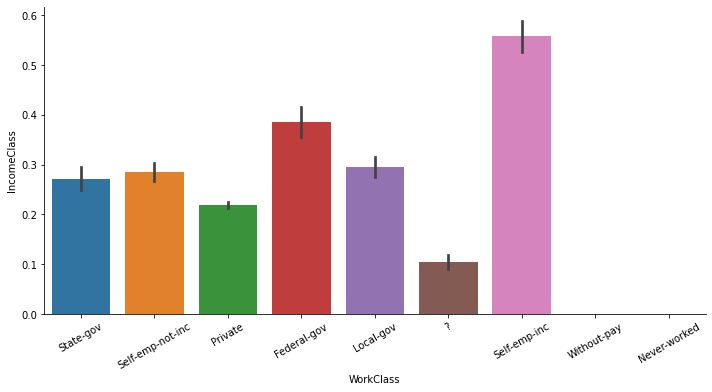

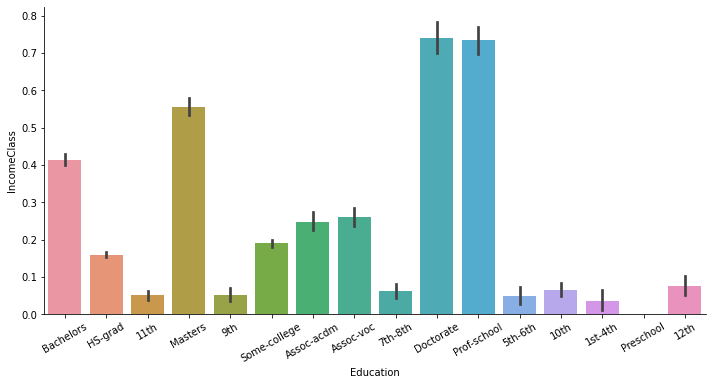

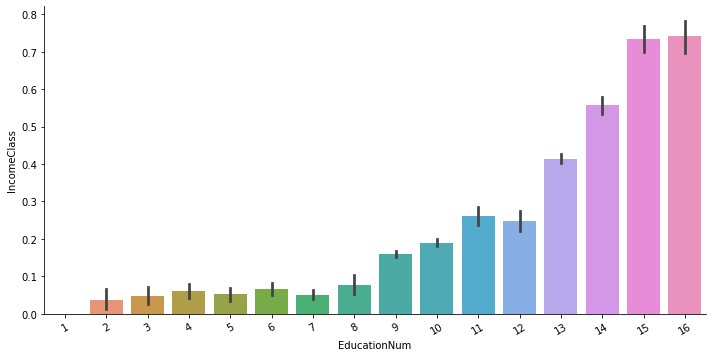

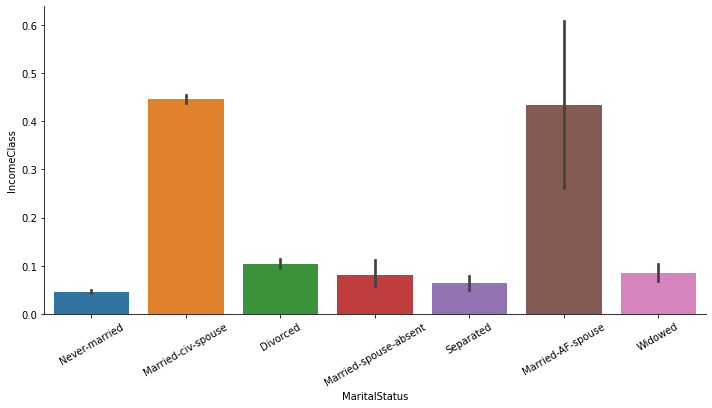

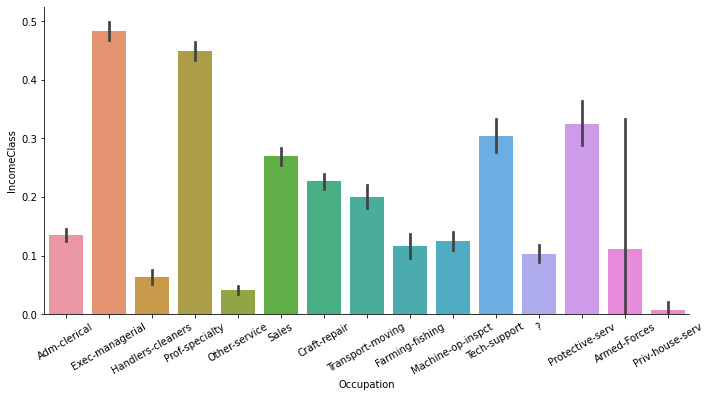

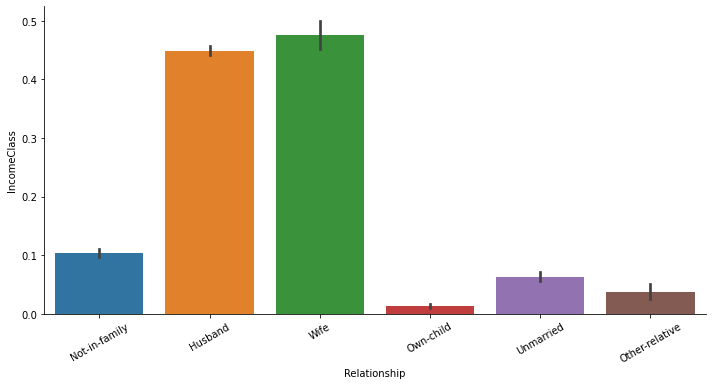

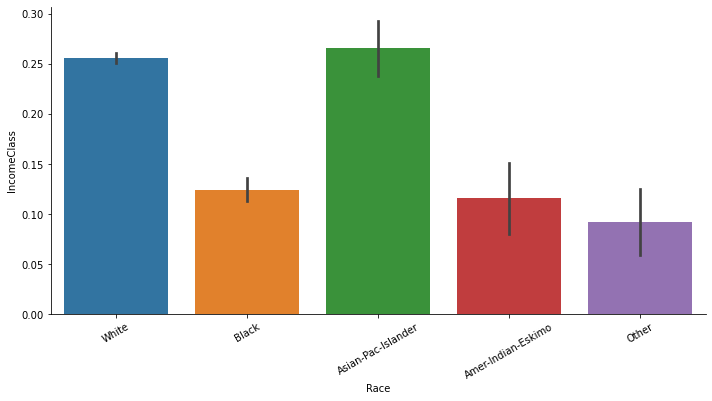

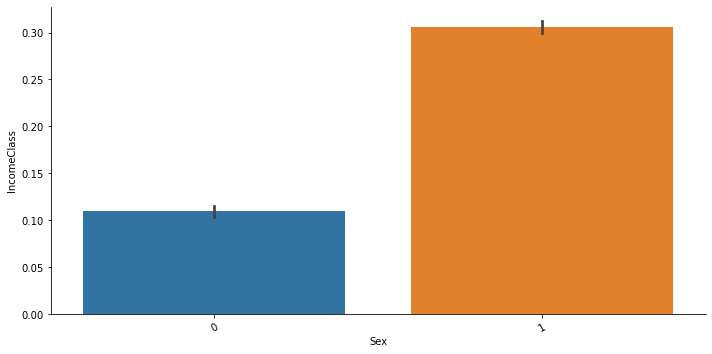

In [3]:
sns.catplot(x='WorkClass', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='Education', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='EducationNum', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='MaritalStatus', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='Occupation', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='Relationship', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='Race', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)
sns.catplot(x='Sex', y='IncomeClass', data=data, kind='bar', aspect=2).set_xticklabels(rotation=30)

Del reporte podemos observar varias cosas:
- **Education** y EducationNum están correlacionadas y esencialmente son equivalentes. Eliminar Education para darle prioridad a la variable numérica podría ser buena idea.
- MaritalStatus y **Relationship** están correlacionadas y esencialmente son equivalentes. Generalmente alguien podría asumir los ingresos si una persona este casado o no, y relationship transmite lo mismo. Como por ejemplo, husband indirectamente significa que una persona está casada. Eliminar Relationship podría ser buena idea.
- Las columnas workclass, occupation y country contienen **?**, que son valores faltantes. Reemplazar ? con el valor más probable sería buena idea. Para practicidad primero voy a usar la moda, aunque podría usar una red para obtener el valor más probable.
- **NativeCoutry** podría ser eliminado o codificada como binaria porque el 90% es United-States pero necesitamos saber si es relevante respecto a el ingreso.
- La diferencia de **CapitalGains** y **CapitalLoss** podría sumariar la combinación a una característica. Si hay ganancias en el año no hay perdidas, la diferencias implicaría que negativos son perdidas.
- CapitalGrains puede ser discretizada dos simples grupos, como tuviste ganancias o no.
- Age puede ser grupos de cada 10 años.
- HoursPerWeek puede ser discretizada como menos horas de las normales, lo normal, y más de lo normal.


También podemos reflexionar sobre las, posibles, variables independientes y dependientes:
- Edad es independiente.
- WorkClass es independiente, no creo que sea verdaderamente dependiente de otras variables.
- FinalWeight como lo indicaba la explicación puede ser dependiente de Race, Age, Sex, Education, EducationNum, MaritalStatus, Occupation, Relationship. Pero no creo que sea de relevancia para el modelo.
- Education es dependiente de la cantidad de años estudiados.
- EducationNum es ligeramente dependiente de Age y Race.
- MaritalStatus es independiente o dependiente de Relationship.
- Occupation podría ser dependiente de los años de educación.
- Relationship es independiente o dependiente de MaritalStatus.
- Race es independiente.

In [4]:
for col in ['WorkClass', 'Occupation', 'NativeCountry']:
    data[col].fillna(data[col].mode()[0], inplace=True)

Para identificar si Country es significativo se puede analizar para cada país, o país diferente a EU, si la probabilidad de tener ingresos por encima de cincuenta mil dólares es diferente a el conjunto de todos los países. La hipótesis es que el país no es muy influyente y, por lo tanto, la probabilidad de tener ingresos por encima de cincuenta mil dólares dado el país es igual independiente del país.

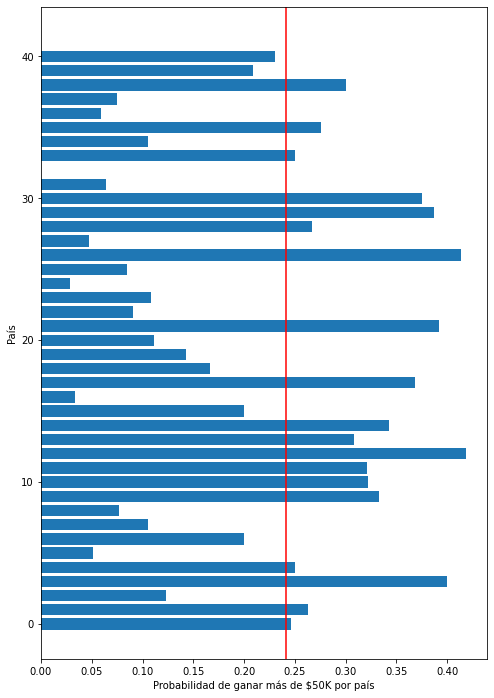

In [5]:
country_list = []
for country in data['NativeCountry'].unique():
    country_list.append( data[data['NativeCountry'] == country]['IncomeClass'].sum() / data[data['NativeCountry'] == country].shape[0] )

plt.figure(figsize=(8, 12))
plt.barh(np.arange(len(data['NativeCountry'].unique())), country_list)
plt.axvline(data['IncomeClass'].sum() / len(data), c='r')
plt.xlabel('Probabilidad de ganar más de $50K por país')
plt.ylabel('País')
plt.show()

Los resultados muestran que dependiendo del país hay influencia por arriba o por debajo del promedio (línea roja). Es recomendable mantenerla.

In [6]:
data[(data['CapitalGain'] != 0) & (data['CapitalLoss'] != 0)]
data['CapitalGain'] = data['CapitalGain'] - data['CapitalLoss']
data['CapitalGain'] = pd.cut(data['CapitalGain'],
                                bins = [data['CapitalGain'].min(), 0, data['CapitalGain'].max()],
                                labels = [0, 1])
data.drop(columns=['CapitalLoss'], inplace=True)

data['HoursPerWeek'] = pd.cut(data['HoursPerWeek'], 
                                bins = [0, 35, 45, 100], 
                                labels = [0, 1, 2])

data['Age'] = pd.cut(data['Age'], 
                    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    labels = [1,2,3,4,5,6,7,8,9,10])


Por último utilizar label encoding facilitara el manejo de las variables discretas.

In [7]:
categorical = ['WorkClass','Education', 'MaritalStatus', 'Occupation', 'Relationship','Race', 'NativeCountry']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        data[feature] = le.fit_transform(data[feature])

Por último, creo que usar las siguientes variables será buen modelo inicial:
- Age
- Sex
- Race
- WorkClass

- EducationNum
- CapitalGain
- Occupation
- Relationship
- HoursPerWeek

In [8]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel([
    ('Age', 'CapitalGain'),
    ('Age', 'EducationNum'),
    ('Age', 'IncomeClass'),
    ('Race', 'EducationNum'),
    ('CapitalGain', 'IncomeClass'),
    ('EducationNum', 'IncomeClass'),
    ('Sex', 'IncomeClass'),
    ('Sex', 'Relationship'),
    ('EducationNum', 'Occupation'),
    ('WorkClass', 'Occupation'),
    ('Occupation', 'IncomeClass'),
    ('Race', 'IncomeClass'),
    ('Relationship', 'IncomeClass'),
    ('Occupation', 'HoursPerWeek'),
    ('Relationship', 'HoursPerWeek'),
    ('HoursPerWeek', 'IncomeClass')
])

C:\Users\nuno\Anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [9]:
model.local_independencies('IncomeClass')

(IncomeClass ⟂ WorkClass | Age, Occupation, CapitalGain, Relationship, Sex, HoursPerWeek, Race, EducationNum)

In [10]:
model.active_trail_nodes('IncomeClass')

{'IncomeClass': {'Age',
  'CapitalGain',
  'EducationNum',
  'HoursPerWeek',
  'IncomeClass',
  'Occupation',
  'Race',
  'Relationship',
  'Sex',
  'WorkClass'}}

## 2. Estimación de parámetros

Estimar los parámetros de la red Bayesiana de acuerdo a un conjunto de datos de entrenamiento. El criterio (máxima verosimilitud o MAP) para estimar los parámetros es de libre elección.

In [11]:
variables = ['Age', 'CapitalGain', 'EducationNum', 'HoursPerWeek', 'Occupation', 'Race', 'Relationship', 'Sex', 'WorkClass']
data_model = data[['Age', 'CapitalGain', 'EducationNum', 'HoursPerWeek', 'Occupation', 'Race', 'Relationship', 'Sex', 'WorkClass', 'IncomeClass']]

train = data_model.sample(frac=0.8)
test = data_model[~data_model.index.isin(train.index)]

model.fit(train, estimator=MaximumLikelihoodEstimator)

print(model.get_cpds('IncomeClass'))

+----------------+-----------------+-----------------+-----+------------------+------------------+
| Age            | Age(2)          | Age(2)          | ... | Age(9)           | Age(9)           |
+----------------+-----------------+-----------------+-----+------------------+------------------+
| CapitalGain    | CapitalGain(0)  | CapitalGain(0)  | ... | CapitalGain(1)   | CapitalGain(1)   |
+----------------+-----------------+-----------------+-----+------------------+------------------+
| EducationNum   | EducationNum(1) | EducationNum(1) | ... | EducationNum(16) | EducationNum(16) |
+----------------+-----------------+-----------------+-----+------------------+------------------+
| HoursPerWeek   | HoursPerWeek(0) | HoursPerWeek(0) | ... | HoursPerWeek(2)  | HoursPerWeek(2)  |
+----------------+-----------------+-----------------+-----+------------------+------------------+
| Occupation     | Occupation(0)   | Occupation(0)   | ... | Occupation(14)   | Occupation(14)   |
+---------

## 3. Entrenar un modelo tipo Naive Bayes

Sobre los mismos datos de entrenamiento del punto 2 y con el mismo cirterio (máxima verosimilitud o MAP), entrena un modelo tipo Naive Bayes.

In [13]:
model_naive = BayesianModel([
    ('IncomeClass', col) for col in variables
])
model_naive.fit(train, estimator=MaximumLikelihoodEstimator)

C:\Users\nuno\Anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


## 4. Evaluación y comparación

Evalúa ambos modelos sobre el conjunto de datos de prueba.

- ¿Qué modelo se comporta mejor? ¿Por qué?

In [38]:
model_pred = model.predict(test.drop(columns=['IncomeClass']).iloc[:100]).values.ravel()

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
model_naive_pred = model_naive.predict(test.drop(columns=['IncomeClass']).iloc[:100]).values.ravel()

  0%|          | 0/100 [00:00<?, ?it/s]

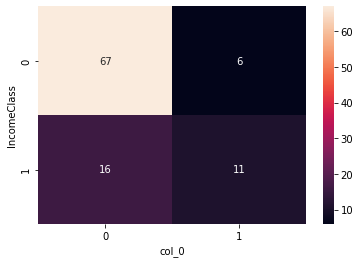

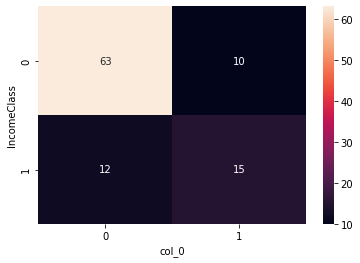

In [42]:
# Matriz de confusión
sns.heatmap(
    pd.crosstab(test['IncomeClass'].iloc[:100], model_pred),
    annot=True
)
plt.show()
sns.heatmap(
    pd.crosstab(test['IncomeClass'].iloc[:100], model_naive_pred),
    annot=True
)
plt.show()

In [41]:
print( "El accuracy para el modelo Bayes es: " + str((test['IncomeClass'].iloc[:100] == model_pred).mean()) )
print( "El accuracy para el modelo Naive Bayes es: " + str((test['IncomeClass'].iloc[:100] == model_naive_pred).mean()) )

El accuracy para el modelo Bayes es: 0.78
El accuracy para el modelo Naive Bayes es: 0.78


El modelo naive mostro ser ligeramente mejor no por la precisión, pero más sencillo de configurar.

Es un método que se vuleve más lento mientras más variables y cardinalidades y dependencias existan. No pude utilizar Country por no parecia terminar despues de horas.

Como conclusión aparte, la creación de redes es complicada al momento de establecer relaciones, incluso teniendo conocimiento del tema. Este tema socioeconómico te pone a pensar que construcciones mentales de que eventos están correlacionados o son dependientes de otros. En los datos hay algunas características que están fuertemente relacionadas y en otros modelos serian mejor eliminarlas. Creo que este data set no refleja las bondades de la metodología, pero expresa lo complicado de crear las relaciones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>